# Data processing of KIE measurement from Mass Spectrometry Data

In [1]:
#import data
import pandas as pd
import numpy as np
import math
from scipy import asarray as ar
from scipy.optimize import leastsq
from scipy import integrate
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob, os

## Preprocessing data
The measurement of different concentration points are exported from machine and stored in .xy form.

In [2]:
#Fetch file list
filelist = []
df = pd.DataFrame()
for file in glob.glob("*.xy"):
    filelist.append(file)
    print(file)

RP2-0.xy
RP2-90a.xy
RP2-30.xy
RP2-70.xy
RP2-50.xy


## Define parameters (peaks)

In [ ]:
def generate_bounds(lb_a, lb_peak, lb_sigma, lb_baseline, peak_number):
    lb_as = [lb_a for i in range(peak_number)]
    lb_peaks = [lb_peak for i in range(peak_number)]
    lb_sigmas = [lb_sigma for i in range(peak_number)]
    exports = list(zip(lb_as,lb_peaks, lb_sigmas))
    exports = list(np.reshape(exports, -1))
    exports.insert(0, lb_baseline)
    return np.array(exports)

In [101]:
#How many peaks you want to include
peak_number = 9

#Peak ranges on the spectrum
peak_range = (1156.0, 1159.0)

#Set initial values for fitting
#center of each peaks 
peak_center_s = [1156.1625, 1156.4968, 1156.8307, 1157.1649, 1157.4991, 1157.8332,
               1158.1668, 1158.5, 1158.8337]
#peak height -- use the same ones
a_s = [30000 for i in range(len(peak_center))]

#Gaussian sigmas -- also use identical ones
sigma_s = [0.1 for i in range(len(peak_center))]

#
baseline = 0

#Generate upper and lower bounds for baseline, as, peaks, peakhights
lower_bound = generate_bounds(0., 1155., 0., 0., 9)
upper_bound = generate_bounds(np.inf, 1159., 0.5, np.inf, 9)
f_bound = (lower_bound, upper_bound)

## Create Gaussian function for fitting
$$
baseline + ae^{- \frac{(x-x1)^2}{2 \sigma ^2}}
$$
baseline + a1*exp(-(x-x1)**2/(2*sigma1**2))

### Setting_fitting_function

In [85]:
def string_for_fitting(peak_number):
    
    function_list = []
    function_vars = []
    for i in range(peak_number):
        component_a = '*np.exp(-(x-'
        component_b = ')**2/(2*'
        component_c = '**2))'
        V1='a' + str(i+1)
        V2='x' + str(i+1)
        V3='sigma'+str(i+1)
        string_gen = V1 +component_a + V2 + \
        component_b + V3 + component_c
        function_list.append(string_gen)
        #generate the function string
        export_str = ""
        #generate the function variable
        function_vars.append(V1)
        function_vars.append(V2)
        function_vars.append(V3)

    #generate function string
    for func in function_list:
            export_str += "+" + func   
    export_str = export_str[1:]
    
    #string for var
    start_string_var = "def gaus(x, baseline"
    for item in function_vars:
        start_string_var += "," + item
    start_string_var += "):\n\t"
    generate_function = start_string_var + "return(baseline + " + export_str + ")"

    return generate_function, export_str

## Fit the peaks

In [102]:
def fit_peaks(x, y, peak_number):
    y_real = y
    import_data = list(zip(a_s, peak_center_s, sigma_s))
    import_data = list(np.reshape(import_data, -1))
    import_data.insert(0, baseline)

    popt,pcov = curve_fit(gaus,x,y,p0=import_data, bounds = f_bound)
    
    y_est = gaus(x, *popt)
    
    plt.plot(x, y_real,'g.',label='Real Data')
    plt.plot(x, y_est, label='Fitted')
    plt.legend()
    plt.show()

    return popt, pcov

## Integrate the peaks to calculate the area

In [104]:
def integration(export_str, peak_number):
    inte_str= "inte = lambda x:" +  export_str
    exec(inte_str)
    #set variables
    for i in range(1,peak_number+1):
        comd1 = "x" + str(i) + "= peak"+str(i)
        comd2 = "a" + str(i) + "= a"+str(i)
        comd3 = "sigma" + str(i) + "= sigma"+str(i)

        print(comd1)
        print(comd2)
        print(comd3)

        exec(comd1)
        exec(comd2)
        exec(comd3)
    integration_result, integration_err = integrate.quad(inte, peak_range[0], peak_range[1] )
    print(integration_result, integration_err)
    return integration_result, integration_err

## Final calculation
### Generate Equation

In [105]:
generate_function, export_str = string_for_fitting(peak_number)
exec(generate_function)

### Fitting loop

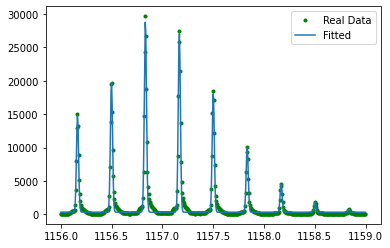

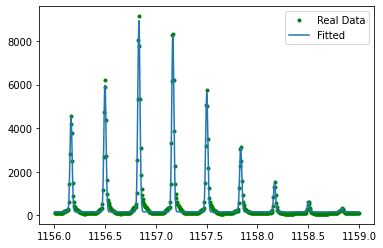

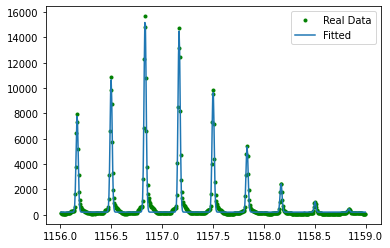

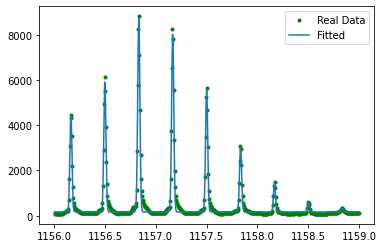

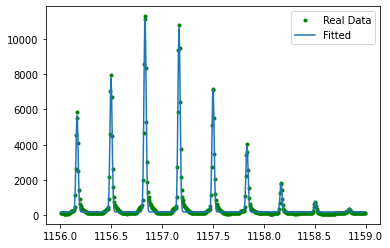

In [107]:
for item in filelist:

    #For each .xy file, data preparation
    data = pd.read_table(item, sep = " ", header = None )
    fname = str(item)

    peaks = data[1].nlargest(5).values
    gauss1 = peaks[2]
    gauss2 = peaks[0]
    middle_point = data[data[1] == gauss1]
    middle_point2 = data[data[1] == gauss2]
    
    fittingData_1 = data[data[0] > peak_range[0]]
    fittingData_2 = fittingData_1[fittingData_1[0] < peak_range[1]]
    x = fittingData_2.iloc[:,0].values
    y = fittingData_2.iloc[:,1].values

    #Ready for fitting
    popt, _ = fit_peaks(x, y, peak_number)

    parameters = []
    for i in range(0,peak_number):
        pp = []
        for j in range(0,3):
            pp.append(popt[j+i*3+1])
        parameters.append(pp)
    
    #set single gaussian
    integration_array = [item]
    for item in parameters:
        a = item[0]
        sigma = item[2]
        x = item[1]
        func = lambda x, a, sigma: a*np.exp(-(x)**2/(2*sigma**2))
        M1, M1_err = integrate.quad(func, -np.inf, np.inf, args = (a, sigma) )
        integration_array.append(M1)

    export_list = []
    for string in integration_array:
        export_list.append(string)

    df[fname] = export_list

## Fitting Result
The result shows surface areas of peaks from 1 to 9 

In [108]:
df

,RP2-0.xy,RP2-90a.xy,RP2-30.xy,RP2-70.xy,RP2-50.xy
0,RP2-0.xy,RP2-90a.xy,RP2-30.xy,RP2-70.xy,RP2-50.xy
1,379.36016,115.588081,200.914163,112.857305,148.536372
2,518.374617,159.810319,274.409417,153.840419,202.418131
3,765.75728,238.778048,409.798355,230.680275,302.871698
4,707.76019,220.810957,379.401816,213.308806,279.14439
5,478.42302,148.895244,254.527133,143.70668,187.34727
6,253.283165,80.35973,137.074781,78.03461,101.893598
7,105.835663,33.463338,56.976236,31.812005,41.23961
8,34.310296,11.079677,18.26443,10.23424,13.176691
9,7.594068,4.200387,5.392131,4.585807,4.343414


In [ ]:
df.to_csv('fitting_result.csv')